In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import center_of_mass 

from libertem.api import Context
from libertem.common import Shape
from libertem.udf.sum import SumUDF
from libertem.udf.sumsigudf import SumSigUDF
from libertem.corrections.coordinates import rotate_deg, flip_y, identity

from ptychography40.reconstruction.wdd.dim_reduct import compress, decompress
from ptychography40.reconstruction.wdd.wdd_udf import WDDUDF, PatchWDDUDF
from ptychography40.reconstruction.wdd.params_recon import wdd_params_recon
from ptychography40.reconstruction.common import wavelength

In [3]:
path = '/storage/er-c-data/adhoc/libertem/libertem-test-data/20200518 165148/default.hdr'#'/cachedata/users/clausen/Ptycho01/20200518 165148/default.hdr'

# Create context
ctx = Context()

/home/weber/miniconda3/envs/lt311/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34445 instead
  warnings.warn(


In [4]:
ds = ctx.load("auto", path=path)

In [5]:
sum_udf = ctx.run_udf(dataset=ds, udf=SumUDF(), progress=True)['intensity'].data

Partitions 0/24, Frames:   0%|          | 0/16384 [00:00<?, ?it/s]

In [6]:
com = scipy.ndimage.center_of_mass(sum_udf)

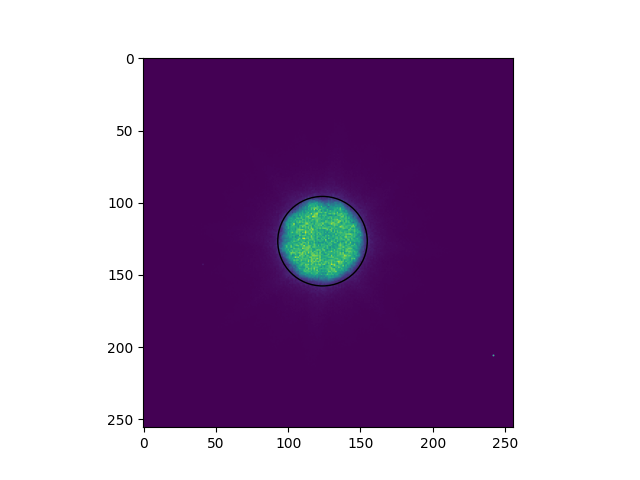

In [7]:
rad = 15.5*2
fig, ax = plt.subplots()
ax.imshow(sum_udf)
circ_a = plt.Circle(np.flip(com),rad, fill=False)
ax.add_artist(circ_a)

## Check Dark Field to get reference coordinate

In [8]:
df = ctx.create_ring_analysis(dataset=ds,
                              cx=com[1], cy=com[0],
                              ri=rad , ro = rad +10)

In [9]:
df_array = ctx.run(df)['intensity']

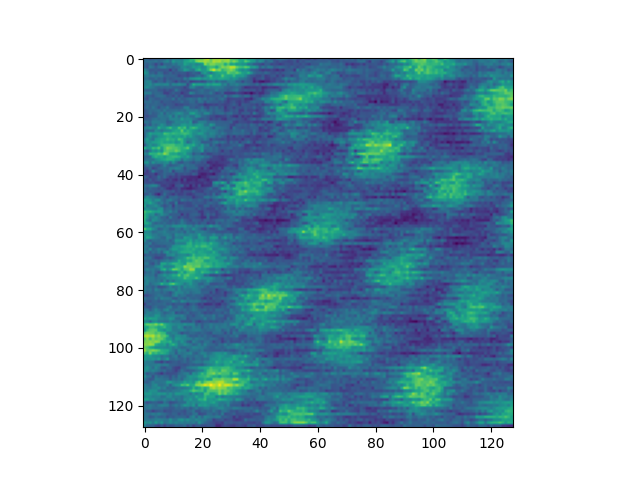

In [10]:
fig, ax = plt.subplots()
ax.imshow(df_array)

# Reconstruction Parameters

### These parameters should be adapted for each dataset

In [11]:
acc = 300# in kV
lamb = wavelength(acc)
scan_real = 0.0127*1e-9 # in m
semiconv= 22.13*1e-3 # In rad
rad = 15.5*2
order = 16
com = com
complex_dtype=np.complex64
float_dtype=np.float32

transformation = rotate_deg(88) @ flip_y()

In [12]:
params = {
    'com':com,
    'dpix': scan_real,
    'lamb':lamb,
    'semiconv_pix':rad,
    'semiconv':semiconv,
    'transformation':transformation,
    'epsilon':1e-6
}

# Calculate parameters

In [13]:
recon_parameters = wdd_params_recon(
    ds_shape=ds.shape,
    params=params, 
)

## Map to lower dimensional and back

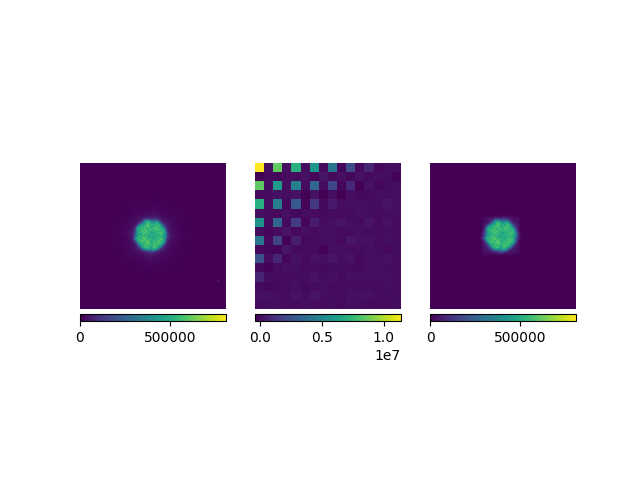

In [14]:
idp_compress = compress(sum_udf, recon_parameters.coeff)
idp_decompress = decompress(idp_compress, recon_parameters.coeff)
fig, (ax1,ax2, ax3) = plt.subplots(1,3)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('bottom', size='5%', pad=0.05)


im1=ax1.imshow(sum_udf, vmin=np.min(sum_udf), vmax = np.max(sum_udf))
im2=ax2.imshow(idp_compress)
im3=ax3.imshow(idp_decompress, vmin=np.min(sum_udf), vmax=np.max(sum_udf))
 
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
fig.colorbar(im1, cax=cax1, orientation='horizontal') 
fig.colorbar(im2, cax=cax2, orientation='horizontal') 
fig.colorbar(im3, cax=cax3, orientation='horizontal') 

## Live WDD Reconstruction

In [15]:
%%time
live_wdd = ctx.run_udf(
    dataset=ds,
    roi=None, 
    udf=WDDUDF(recon_parameters),
    #progress=True
    #plots=[['amplitude', 'phase']]
)

live_wdd_recon = live_wdd['reconstructed']

CPU times: user 292 ms, sys: 288 ms, total: 580 ms
Wall time: 2.16 s


## Live WDD Reconstruction using patches

Reconstruct patches of the input data individually and merge by overlaying patches and adjusting their phases.

This scales much better for large field of view, but may introduce artifacts. Larger patch overlap and trim reduces the artifacts, while smaller overlap and trim speed up the calculation. An intermediate patch shape between 32x32 and 64x64 seems to yield good result quality at good speed.

Please note that the overlaying process is repeated many times for live results, which can consume significant resources. Larger patches reduce the impact.

In [16]:
recon_parameters_patch = wdd_params_recon(
    ds_shape=ds.shape,
    params=params,
    patch_shape=(56, 56)
)

In [17]:
%%time
%autoreload
patch_udf = PatchWDDUDF(recon_parameters_patch, patch_overlap=8, patch_trim=8)
print("Patch step: ", patch_udf.patch_step)
live_wdd_patch = ctx.run_udf(
    dataset=ds,
    roi=None, 
    udf=patch_udf,
    #plots=[['amplitude', 'phase']]
)

live_wdd_recon_patch = live_wdd['reconstructed']

Patch step:  (32, 32)
CPU times: user 483 ms, sys: 2.21 s, total: 2.69 s
Wall time: 758 ms


/home/weber/ptychography/src/ptychography40/stitching/stitching.py:94: RuntimeWarning: invalid value encountered in divide
  result /= count


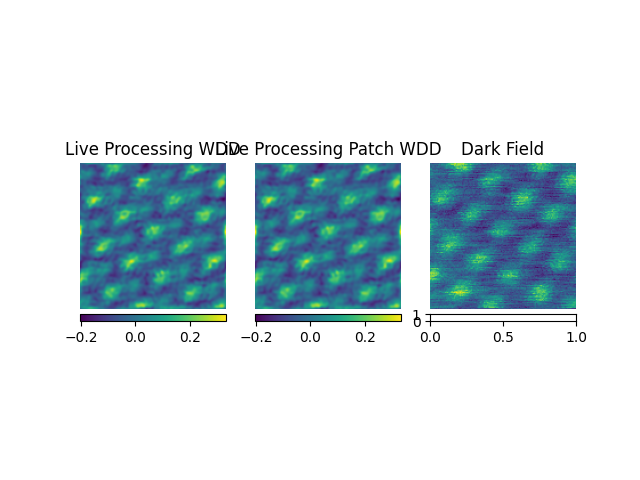

In [18]:

fig,(ax1,ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True)
#fig.tight_layout()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
im1 = ax1.imshow(np.angle(live_wdd_recon))

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('bottom', size='5%', pad=0.05)
im2 = ax2.imshow(np.angle(live_wdd_recon_patch))

divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('bottom', size='5%', pad=0.05)
im3 = ax3.imshow(df_array)

ax1.set_axis_off()
ax1.set_title('Live Processing WDD')

ax2.set_axis_off()
ax2.set_title('Live Processing Patch WDD')

ax3.set_axis_off()
ax3.set_title('Dark Field')

fig.colorbar(im1, cax=cax1, orientation='horizontal') 
fig.colorbar(im2, cax=cax2, orientation='horizontal') 


In [19]:
%%time
dd = []
dam = [] 
for udf_results in ctx.run_udf_iter(dataset=ds, roi = None, 
                       udf= WDDUDF(recon_parameters)):
    dd.append(np.copy(udf_results.buffers[0]['reconstructed'].data))
    dam.append(np.copy(udf_results.damage.data))

CPU times: user 179 ms, sys: 162 ms, total: 341 ms
Wall time: 1.38 s


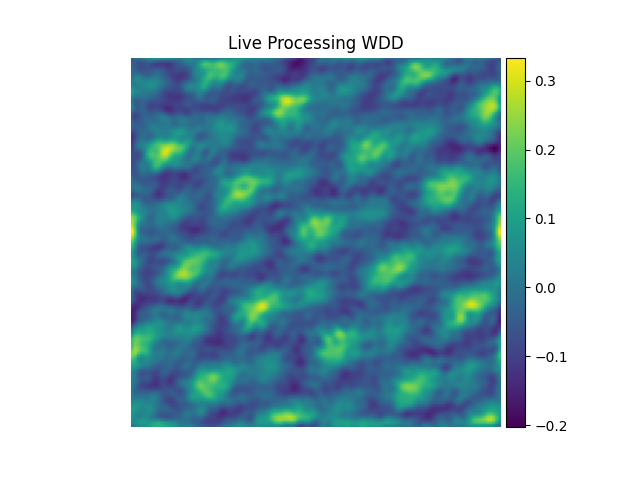

In [20]:

fig,ax = plt.subplots()
#fig.tight_layout()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(np.angle(live_wdd_recon))
ax.set_axis_off()
ax.set_title('Live Processing WDD')
fig.colorbar(im, cax=cax, orientation='vertical') 

In [21]:
idx_buffer = np.ceil(np.linspace(10,len(dam)-1,5)).astype(int)

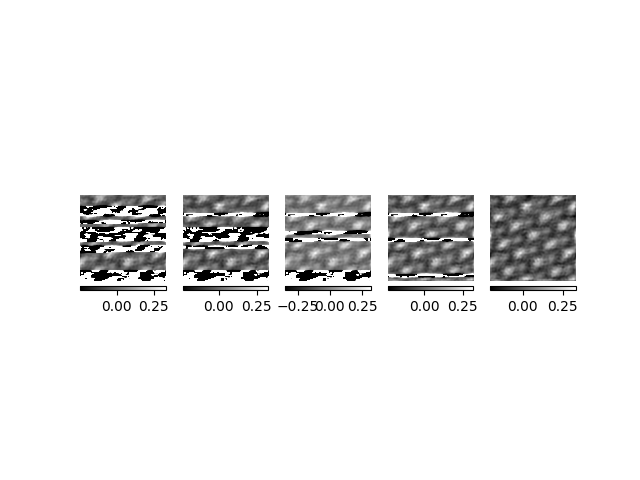

In [22]:
fig, ax = plt.subplots(1,len(idx_buffer), constrained_layout=False)

for id_buff in range(len(idx_buffer)):
    divider = make_axes_locatable(ax[id_buff])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    idx_show = idx_buffer[id_buff]
    
    vmin = np.min(np.angle(dd[idx_show])[dam[idx_show]])
    vmax = np.max(np.angle(dd[idx_show])[dam[idx_show]])
    im = ax[id_buff].imshow(np.angle(dd[idx_show]), vmin=vmin,vmax=vmax,cmap = 'gray')
    ax[id_buff].set_axis_off()
    fig.colorbar(im, cax=cax, orientation='horizontal')